In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive/')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive/


In [ ]:
!pip install transformers
from transformers import BertForSequenceClassification,AutoTokenizer
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# 1-Carga de datos de entrenamiento y validación

In [ ]:
# Datos de entrenamiento
train_data = pd.read_csv("/content/drive/MyDrive/TFM_Pruebas_Investigación/Datos/Entrenamiento_Clasificador/preguntas_entrenamiento_postproc.csv", encoding="utf-8")
pd.set_option("display.max_colwidth", None)  # Esto es para no truncar la columna de respuesta
train_data.columns
# print(train_data)
# Dividir en conjuntos de entrenamiento y validación. random state = 42 es el valor ejemplo de la documentación de scikit learn
# https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_data["frase"].tolist() ,train_data["clase"].tolist(), test_size=0.3, random_state=42
)
# Extración dinámica de número de clases.
#Esto es un parametro de entrada que se utilizará al seleccionar el modelo
num_class = len(set(label for label in train_labels))
print(f"Número de clases: {num_class}")

Número de clases: 12


# 2-Carga del modelo
https://huggingface.co/dccuchile/bert-base-spanish-wwm-uncased
A la hora de invocar el modelo, las funciones que empiezan por TF son para TensorFlow mientras que las que no empiezan por TF son para Pytorch.


In [ ]:
# Modelo BETO en Huggingface
model_name='dccuchile/bert-base-spanish-wwm-uncased'
"""
¡Cuidado! El tokenizador ofrecido por HugginFace para BERT
por defecto es BERTTokenizer, que utiliza WordPiece.
Si usamos AutoTokenizer utilizaremos el tokenizador entrenado en BETO (byte pair).
"""
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_class)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/310 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/486k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 3-Tokenizar la columna de frases para convertirla en una representación numérica.

In [ ]:
# Tokenizar los datos.
"""
Crear una función para no tener que introducir los mismos parametros
de tokenización para entrenamientoy validación.
"""
def tokenize_data(texts, tokenizer, max_length=50):
    return tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

train_encodings = tokenize_data(train_texts, tokenizer)
val_encodings = tokenize_data(val_texts, tokenizer)


In [ ]:
print(tokenize_data(train_texts, tokenizer))

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

{'input_ids': tensor([[    4,  1041,  2343,  ...,     1,     1,     1],
        [    4,  1057,  1428,  ...,     1,     1,     1],
        [    4,  1484,  6307,  ...,     1,     1,     1],
        ...,
        [    4,  1039,  1363,  ...,     1,     1,     1],
        [    4,  2418, 22418,  ...,     1,     1,     1],
        [    4,  1041, 22365,  ...,     1,     1,     1]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


In [ ]:
print(train_texts[0])
print(tokenizer.encode(train_texts[0]))
print(train_encodings["input_ids"][0])
print(train_texts[1])
print(tokenizer.encode(train_texts[1]))
print(train_encodings["input_ids"][1])
print(train_encodings["token_type_ids"][1])
print(train_encodings["attention_mask"][1])
#PreTrainedTokenizer.call()

que actividades economicas suelen incluirse en el regimen especial del recargo de equivalencia
[4, 1041, 2343, 3670, 1800, 8514, 27619, 1035, 1039, 1363, 4157, 2265, 1081, 17562, 1110, 1009, 20126, 30959, 1143, 5]
tensor([    4,  1041,  2343,  3670,  1800,  8514, 27619,  1035,  1039,  1363,
         4157,  2265,  1081, 17562,  1110,  1009, 20126, 30959,  1143,     5,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1])
se puede deducir el iva de la compra de una moto de reparto si se usa para fines profesionales y privados
[4, 1057, 1428, 22418, 1039, 14438, 1009, 1032, 6716, 1009, 1091, 8867, 1009, 11830, 1096, 1057, 5315, 1097, 4836, 5733, 1040, 10080, 5]
tensor([    4,  1057,  1428, 22418,  1039, 14438,  1009,  1032,  6716,  1009,
         1091,  8867,  1009, 11830,  1096,  1057,  5315,  1097,  4836,  57

In [ ]:
print(train_encodings.keys())
print(train_encodings["input_ids"][0])
print(train_encodings["token_type_ids"][0])
print(train_encodings["attention_mask"][0])
print(train_encodings.keys())
print(train_encodings["input_ids"][5])
print(train_encodings["token_type_ids"][5])
print(train_encodings["attention_mask"][5])

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
tensor([    4,  1041,  2343,  3670,  1800,  8514, 27619,  1035,  1039,  1363,
         4157,  2265,  1081, 17562,  1110,  1009, 20126, 30959,  1143,     5,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
tensor([    4,  1041,  6594,  7033,  4685,  1039, 17562,  1110,  1009, 20126,
        30959,  1143,     5,     1,     1,     1,     1,   

In [ ]:
# Construir un dataloader personalizado para el conjunto de datos particular
# interesante este tutorial para datasets customizados: https://huggingface.co/transformers/v3.5.1/custom_datasets.html
class DatasetPreguntasIVA(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

# Aplicar la subclase a los encodings para obtener el dataset de entrenamiento definitivo
train_dataset = DatasetPreguntasIVA(train_encodings, train_labels)
val_dataset = DatasetPreguntasIVA(val_encodings, val_labels)

#print(train_encodings.encodings[0])
print(train_dataset[0])
#train_dataset[0]

{'input_ids': tensor([    4,  1041,  2343,  3670,  1800,  8514, 27619,  1035,  1039,  1363,
         4157,  2265,  1081, 17562,  1110,  1009, 20126, 30959,  1143,     5,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]), 'labels': tensor(4)}



data = train_iterator.dataset.data
shape = train_iterator.dataset.data.shape  
datatype = train_iterator.dataset.data.dtype

# Fine tuning

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

next(iter(train_dataloader ))

{'input_ids': tensor([[    4,  1054,  3342,  1041, 24345,  1152,  1091,  2486,  1105,  1008,
              5,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
         [    4,  1862, 13137,  1190,  1041,  1028,  1039, 17562,  1110,  1009,
          20126, 30959,  1143,     5,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
         [    4,  1506,  1041,  7085,  1484,  1526,  1097,  3729,  1039,  4209,
           2286, 31000,     5,     1,     1,     1,     1,     1,     1,     1,
              1,     1,  

In [ ]:
from transformers import AdamW, get_scheduler

# Definir el optimizador
optimizer = AdamW(model.parameters(), lr=6e-7,betas=(0.9,0.999),weight_decay = 0.0001)
epochs = 30
# Definir el programador de tasa de aprendizaje
num_training_steps = len(train_dataloader) * epochs # épocas
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=1, num_training_steps=num_training_steps
)


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


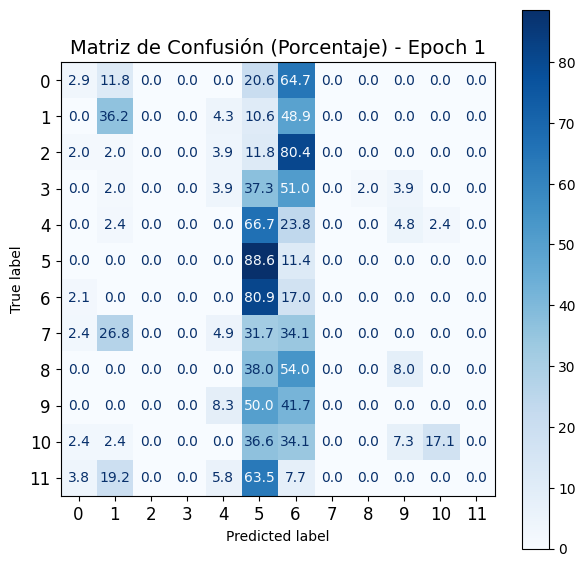

Epoch 1: Train Loss = 2.4651, Train Accuracy = 0.1105, Val Loss = 2.3712, Val Accuracy = 0.1314


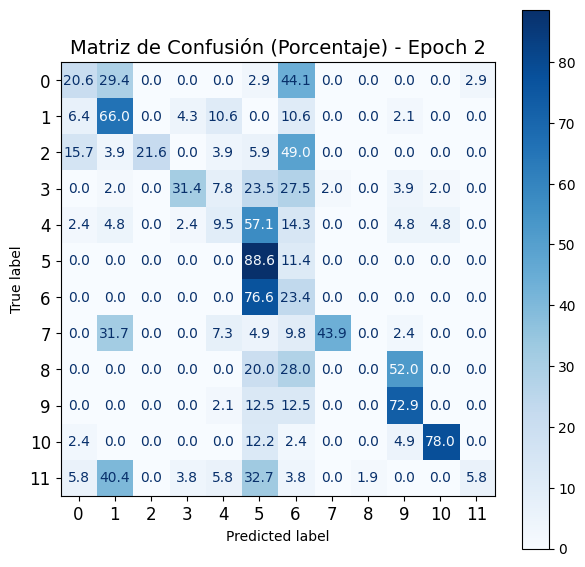

Epoch 2: Train Loss = 2.3443, Train Accuracy = 0.1991, Val Loss = 2.2441, Val Accuracy = 0.3777


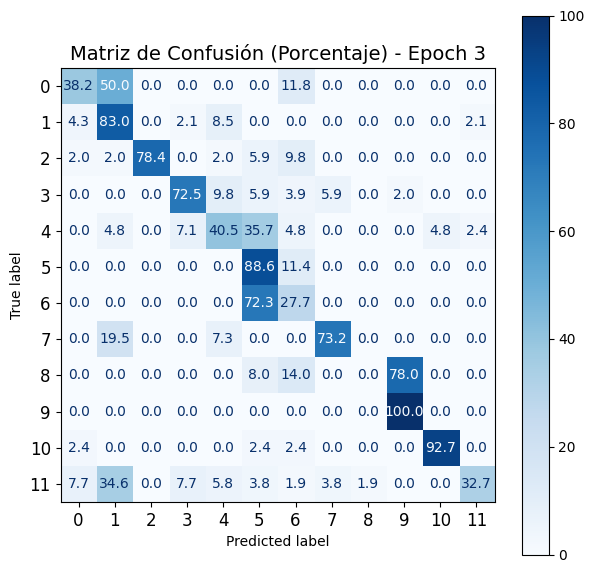

Epoch 3: Train Loss = 2.2242, Train Accuracy = 0.3997, Val Loss = 2.0852, Val Accuracy = 0.6040


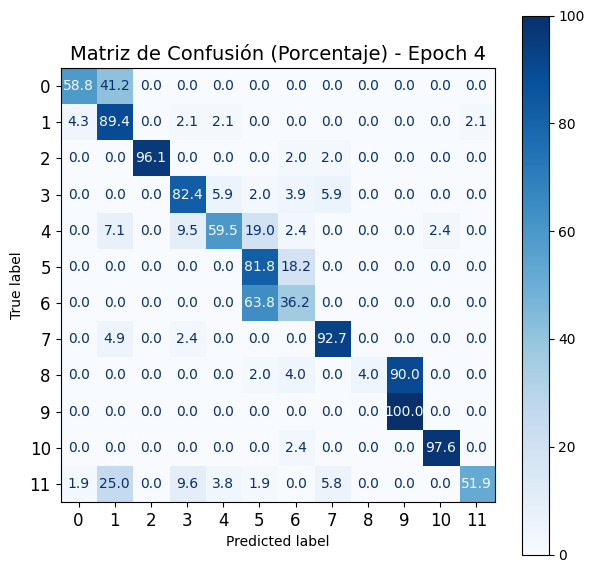

Epoch 4: Train Loss = 2.0991, Train Accuracy = 0.5721, Val Loss = 1.9323, Val Accuracy = 0.7044


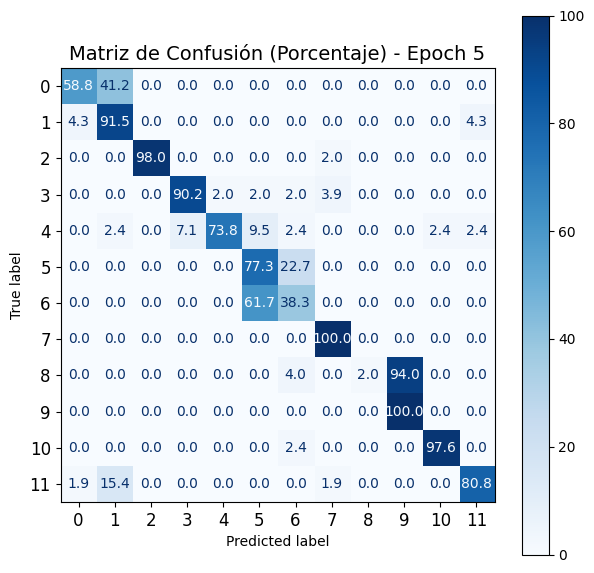

Epoch 5: Train Loss = 1.9649, Train Accuracy = 0.6850, Val Loss = 1.7756, Val Accuracy = 0.7555


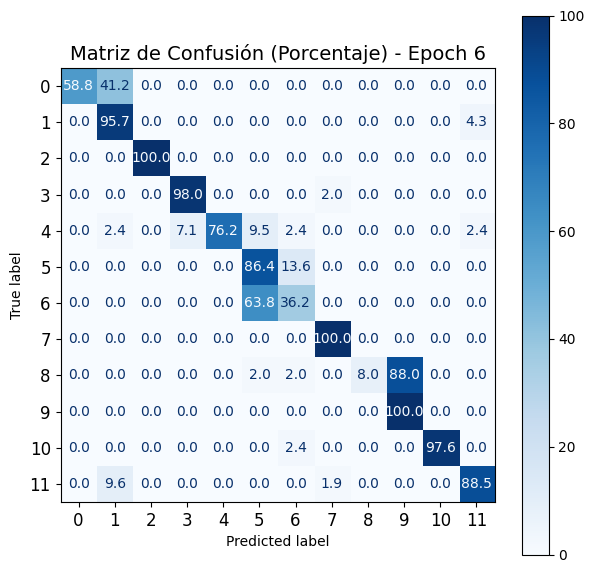

Epoch 6: Train Loss = 1.8338, Train Accuracy = 0.7578, Val Loss = 1.6307, Val Accuracy = 0.7883


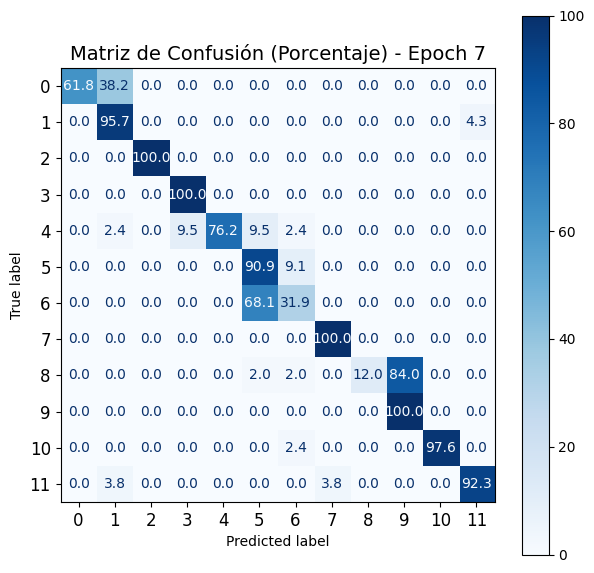

Epoch 7: Train Loss = 1.7073, Train Accuracy = 0.7994, Val Loss = 1.4963, Val Accuracy = 0.7993


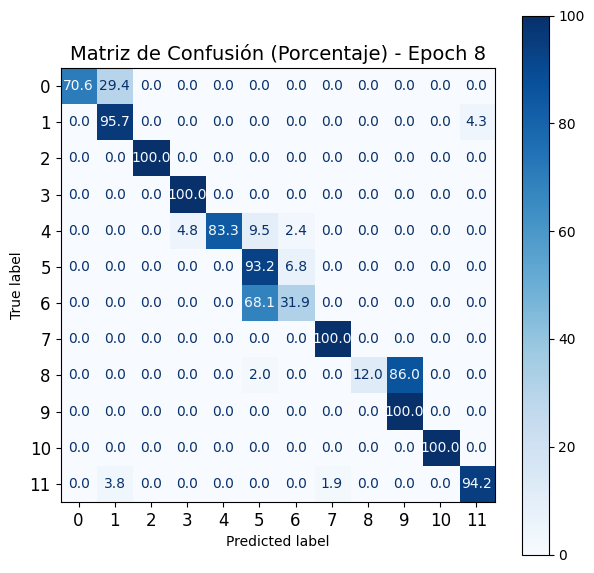

Epoch 8: Train Loss = 1.5905, Train Accuracy = 0.8174, Val Loss = 1.3671, Val Accuracy = 0.8157


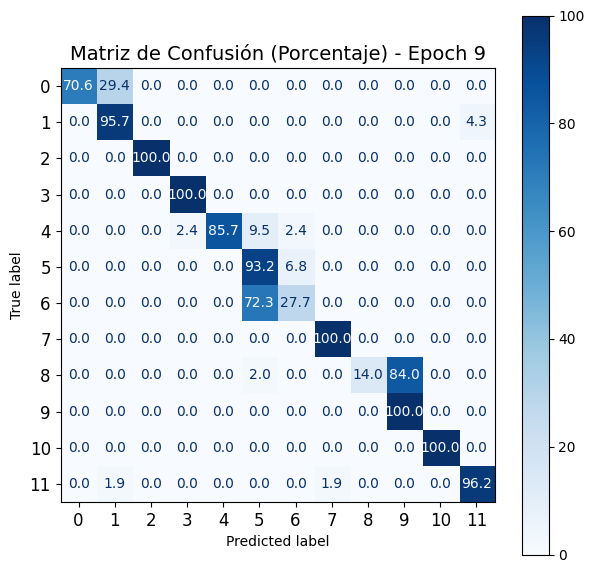

Epoch 9: Train Loss = 1.4821, Train Accuracy = 0.8401, Val Loss = 1.2547, Val Accuracy = 0.8175


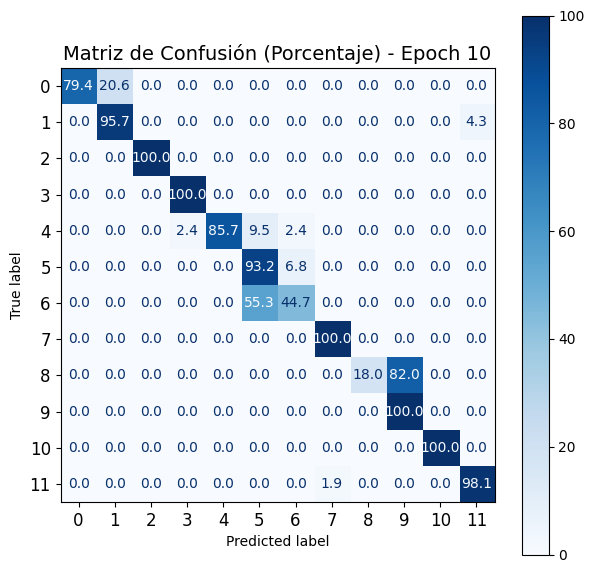

Epoch 10: Train Loss = 1.3845, Train Accuracy = 0.8527, Val Loss = 1.1604, Val Accuracy = 0.8431


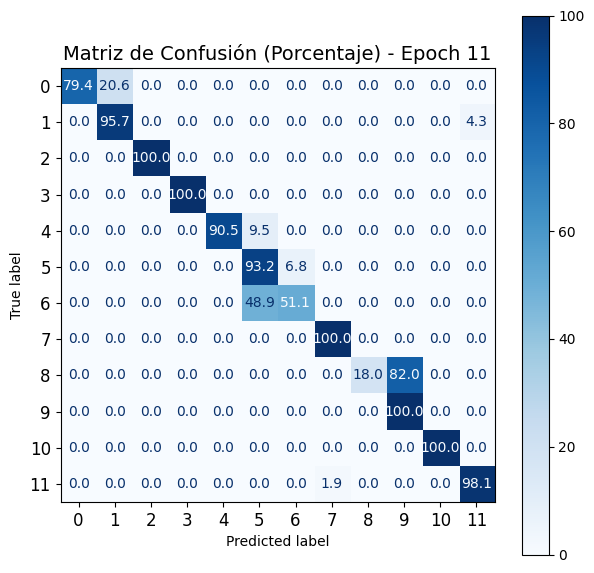

Epoch 11: Train Loss = 1.2965, Train Accuracy = 0.8793, Val Loss = 1.0874, Val Accuracy = 0.8522


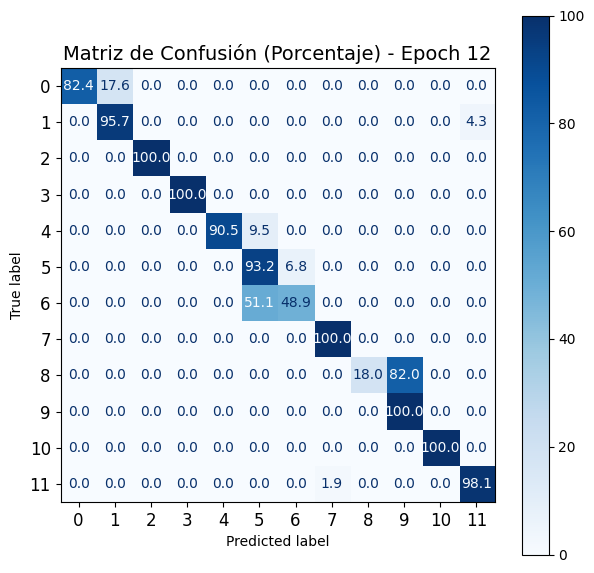

Epoch 12: Train Loss = 1.2151, Train Accuracy = 0.8715, Val Loss = 1.0087, Val Accuracy = 0.8522


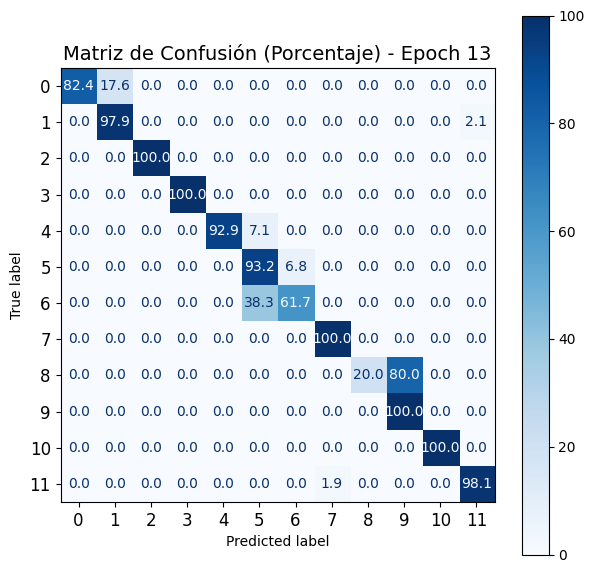

Epoch 13: Train Loss = 1.1430, Train Accuracy = 0.8824, Val Loss = 0.9425, Val Accuracy = 0.8686


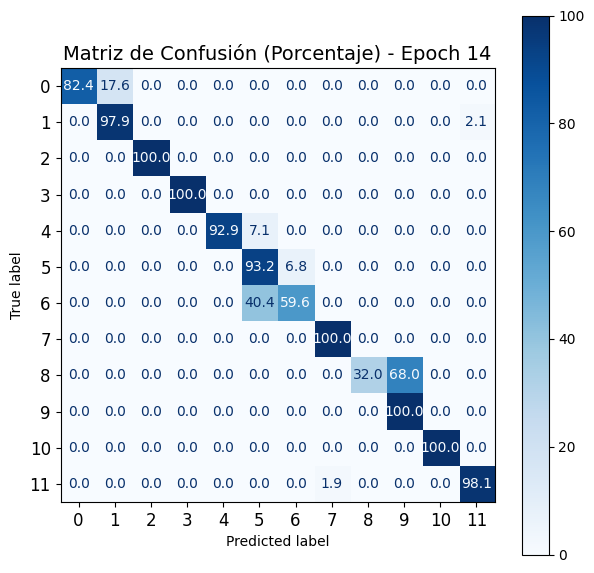

Epoch 14: Train Loss = 1.0810, Train Accuracy = 0.8895, Val Loss = 0.8819, Val Accuracy = 0.8777


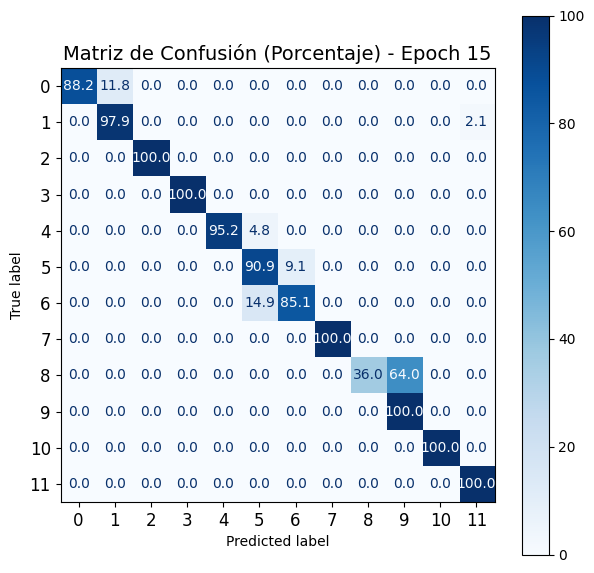

Epoch 15: Train Loss = 1.0240, Train Accuracy = 0.8997, Val Loss = 0.8392, Val Accuracy = 0.9088


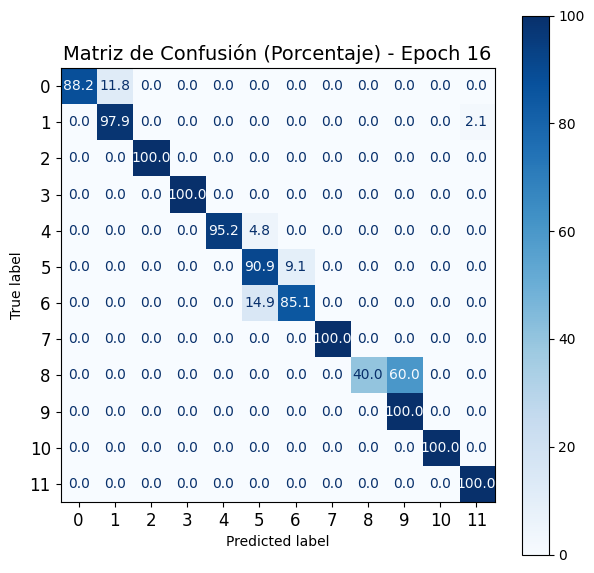

Epoch 16: Train Loss = 0.9748, Train Accuracy = 0.9020, Val Loss = 0.7879, Val Accuracy = 0.9124


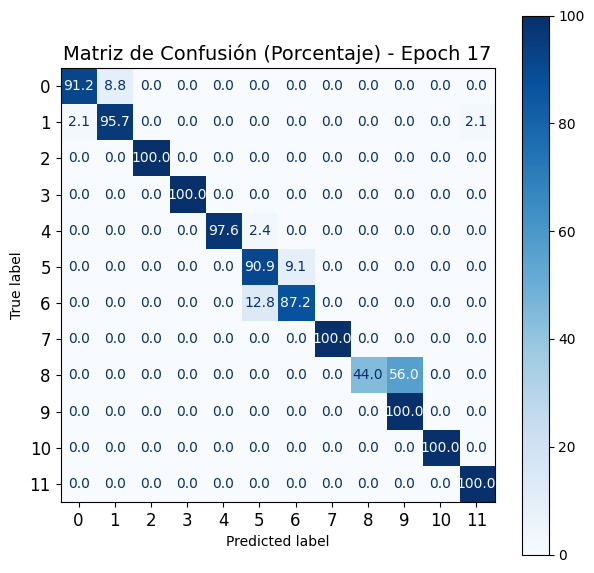

Epoch 17: Train Loss = 0.9358, Train Accuracy = 0.8966, Val Loss = 0.7638, Val Accuracy = 0.9197


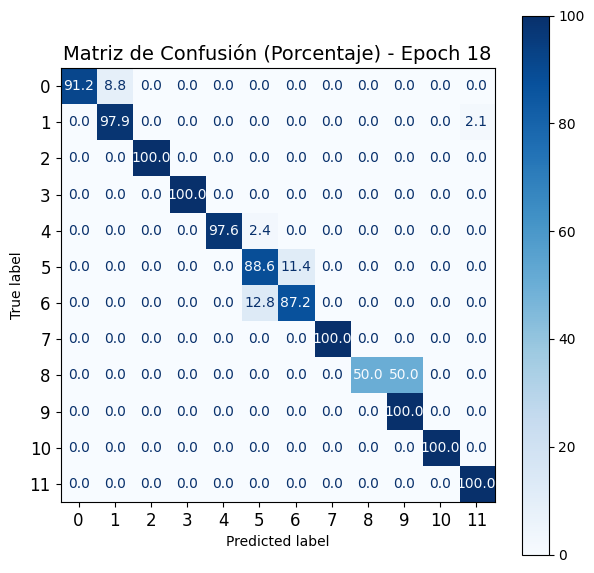

Epoch 18: Train Loss = 0.8916, Train Accuracy = 0.8989, Val Loss = 0.7291, Val Accuracy = 0.9252


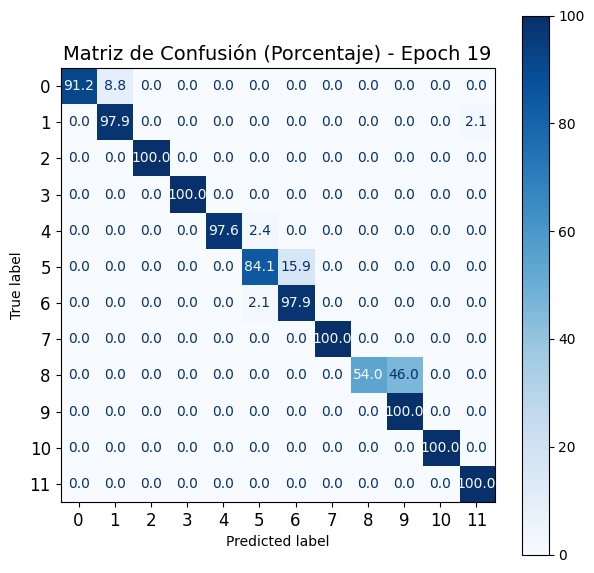

Epoch 19: Train Loss = 0.8620, Train Accuracy = 0.9075, Val Loss = 0.7035, Val Accuracy = 0.9343


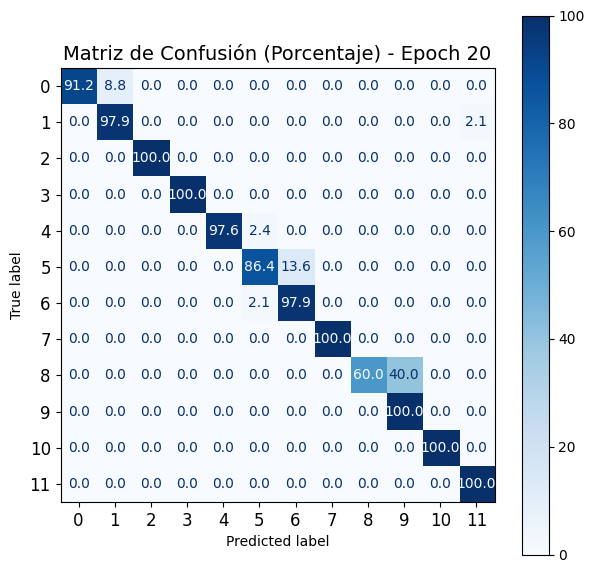

Epoch 20: Train Loss = 0.8307, Train Accuracy = 0.9130, Val Loss = 0.6760, Val Accuracy = 0.9416


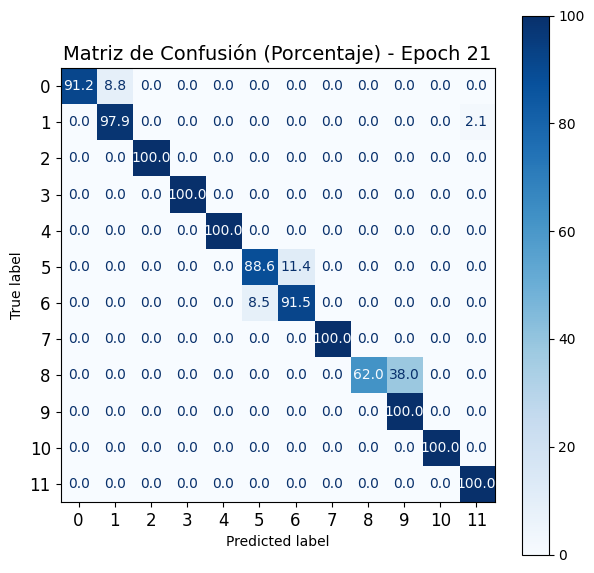

Epoch 21: Train Loss = 0.8118, Train Accuracy = 0.9107, Val Loss = 0.6484, Val Accuracy = 0.9416


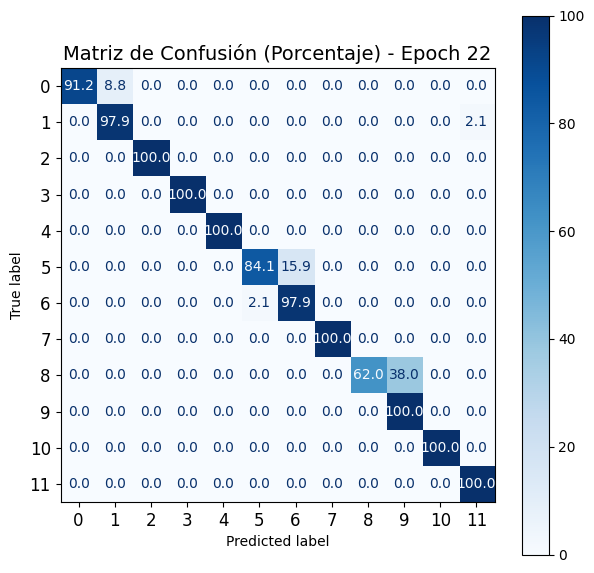

Epoch 22: Train Loss = 0.7793, Train Accuracy = 0.9154, Val Loss = 0.6440, Val Accuracy = 0.9434


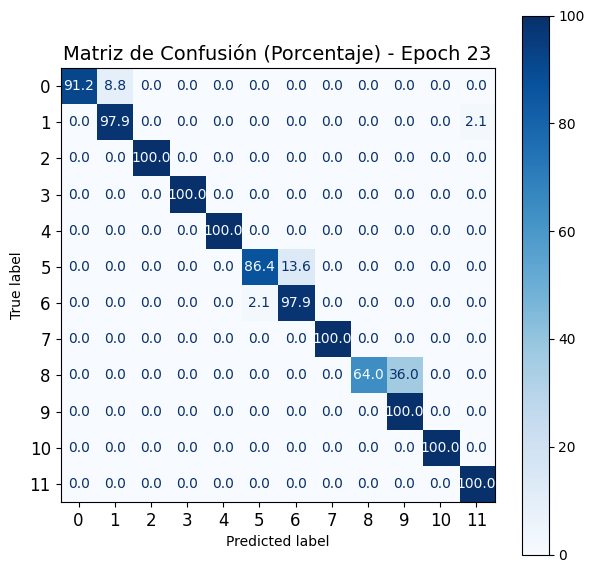

Epoch 23: Train Loss = 0.7657, Train Accuracy = 0.9201, Val Loss = 0.6264, Val Accuracy = 0.9471


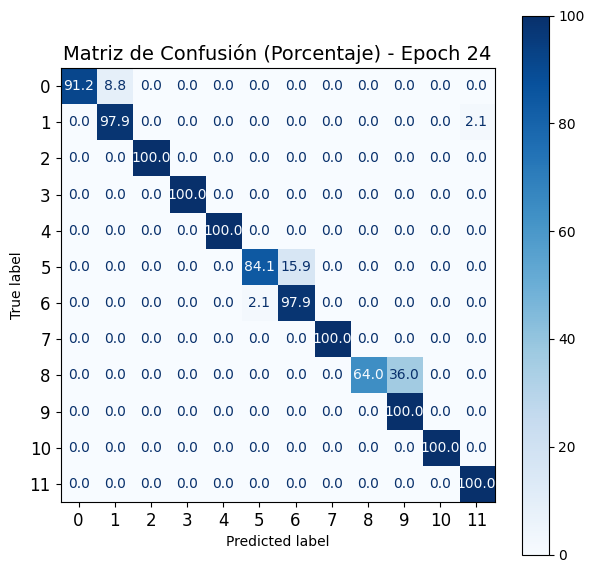

Epoch 24: Train Loss = 0.7438, Train Accuracy = 0.9216, Val Loss = 0.6056, Val Accuracy = 0.9453


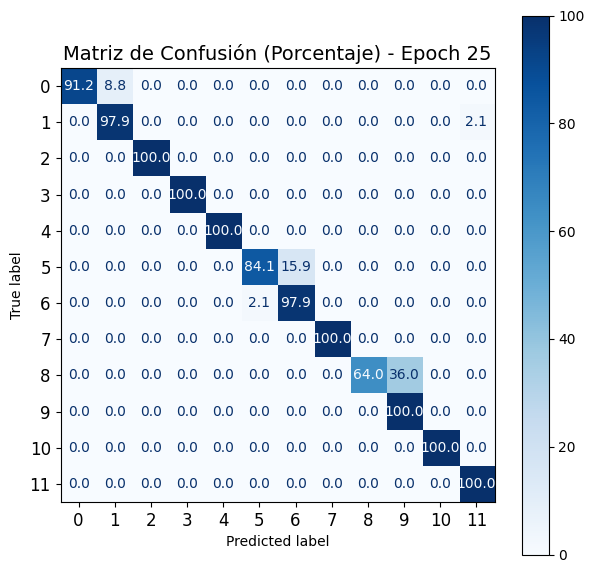

Epoch 25: Train Loss = 0.7341, Train Accuracy = 0.9154, Val Loss = 0.6024, Val Accuracy = 0.9453


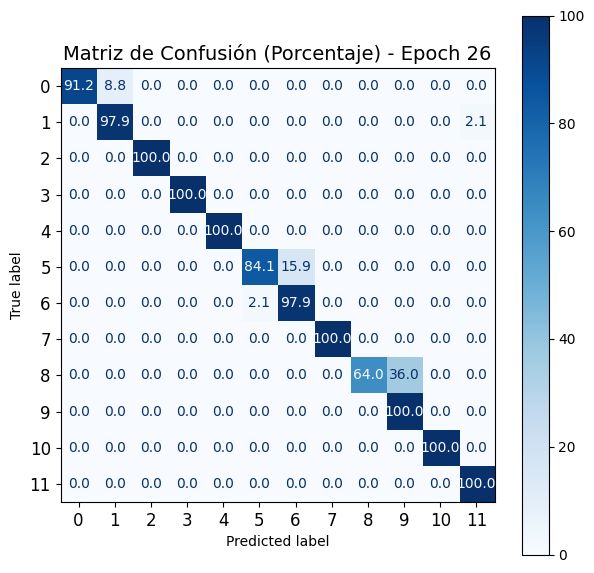

Epoch 26: Train Loss = 0.7218, Train Accuracy = 0.9216, Val Loss = 0.5779, Val Accuracy = 0.9453


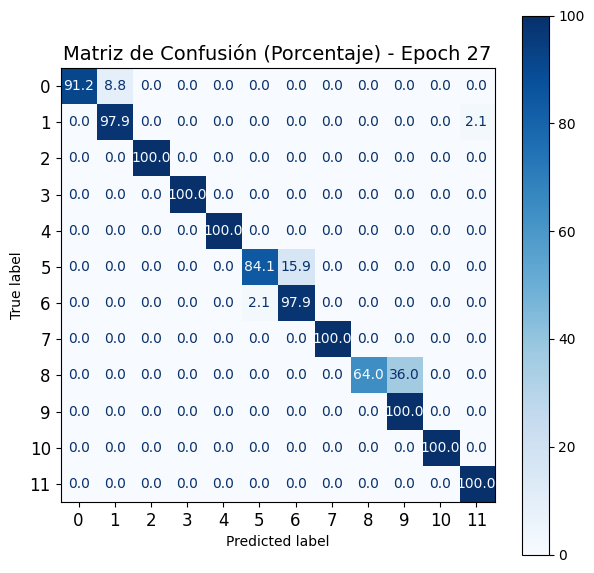

Epoch 27: Train Loss = 0.7144, Train Accuracy = 0.9295, Val Loss = 0.5857, Val Accuracy = 0.9453


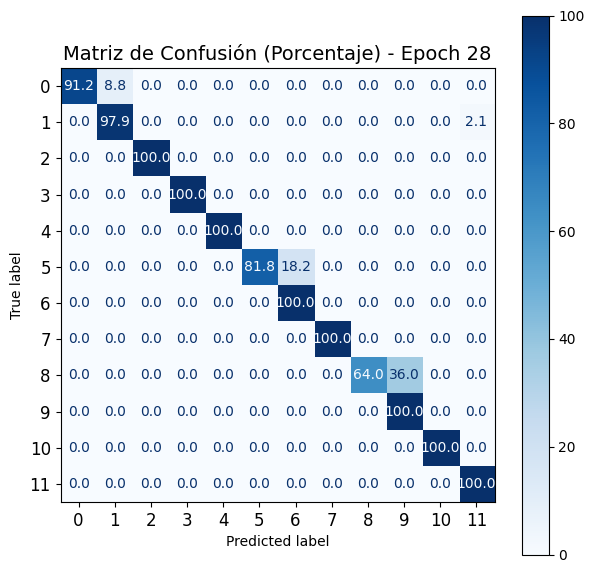

Epoch 28: Train Loss = 0.7095, Train Accuracy = 0.9146, Val Loss = 0.5798, Val Accuracy = 0.9453


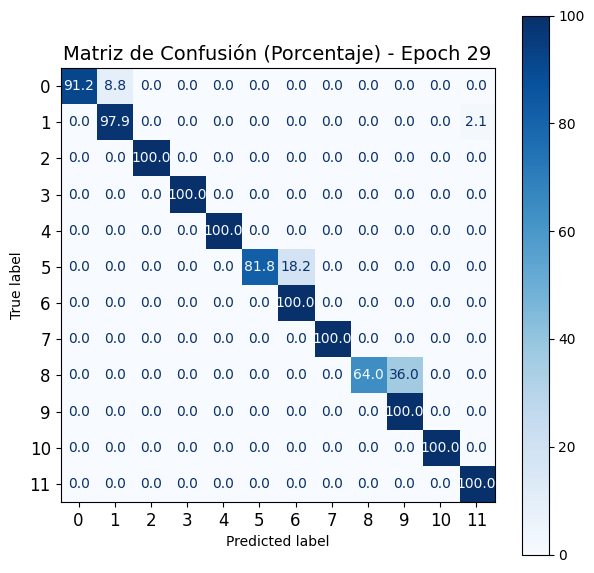

Epoch 29: Train Loss = 0.6993, Train Accuracy = 0.9255, Val Loss = 0.5643, Val Accuracy = 0.9453


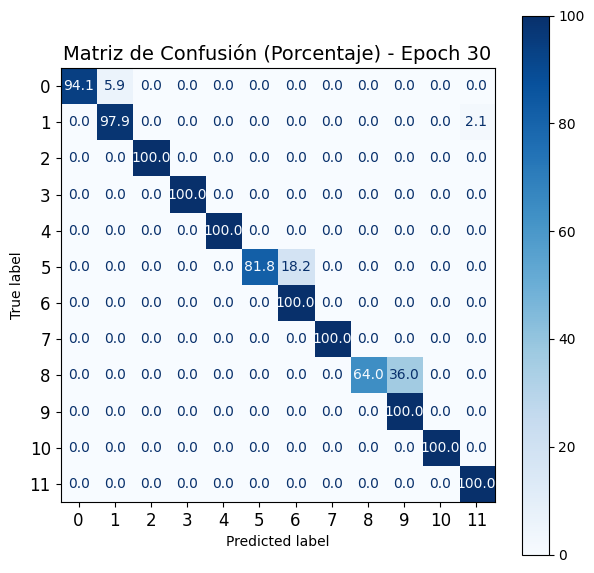

Epoch 30: Train Loss = 0.7051, Train Accuracy = 0.9208, Val Loss = 0.5798, Val Accuracy = 0.9471


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import torch.nn.functional as F  # Para usar softmax

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# iniciar listas vacías para registrar la pérdida y precisión
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    #iniciar listas vacías para recolectar predicciones y etiquetas durante el entrenamiento
    all_train_predictions = []
    all_train_labels = []

    # ENTRENAMIENTO
    for batch in train_dataloader:
        batch = {key: val.to(device) for key, val in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()

        # predicciones train accuracy
        logits = outputs.logits
        probabilities = F.softmax(logits, dim=-1)
        predictions = torch.argmax(probabilities, dim=-1)

        # Almacenar las predicciones y etiquetas la accuracy de train
        all_train_predictions.extend(predictions.cpu().numpy())
        all_train_labels.extend(batch["labels"].cpu().numpy())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # se calcula train accuracy
    train_accuracy = accuracy_score(all_train_labels, all_train_predictions)
    train_accuracies.append(train_accuracy)

    # VALIDACIÓN
    model.eval()
    total_val_loss = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in val_dataloader:
            batch = {key: val.to(device) for key, val in batch.items()}

            outputs = model(**batch)
            loss = outputs.loss
            total_val_loss += loss.item()

            logits = outputs.logits

            # Aplicar softmax a los logits para calcular probabilidades
            probabilities = F.softmax(logits, dim=-1)
            predictions = torch.argmax(probabilities, dim=-1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(batch["labels"].cpu().numpy())

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    # Precision val
    val_accuracy = accuracy_score(all_labels, all_predictions)
    val_accuracies.append(val_accuracy)

    # Generar la matriz de confusión en porcentaje
    conf_matrix = confusion_matrix(all_labels, all_predictions, normalize='true') * 100
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                  display_labels=sorted(set(all_labels)))
    #matriz de confusión formateando decentemente los decimales
    fig, ax = plt.subplots(figsize=(7, 7))  # Ajuste del tamaño de la figura
    disp.plot(ax=ax, cmap=plt.cm.Blues, values_format=".1f")  #Mostrar valores con un decimal
    # Ajustar los parametros de visualización de etiquetas
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(f"Matriz de Confusión (Porcentaje) - Epoch {epoch + 1}", fontsize=14)
    plt.show()
    # Mostrar resultados de la epoch
    print(f"Epoch {epoch + 1}: "
          f"Train Loss = {avg_train_loss:.4f}, "
          f"Train Accuracy = {train_accuracy:.4f}, "
          f"Val Loss = {avg_val_loss:.4f}, "
          f"Val Accuracy = {val_accuracy:.4f}")

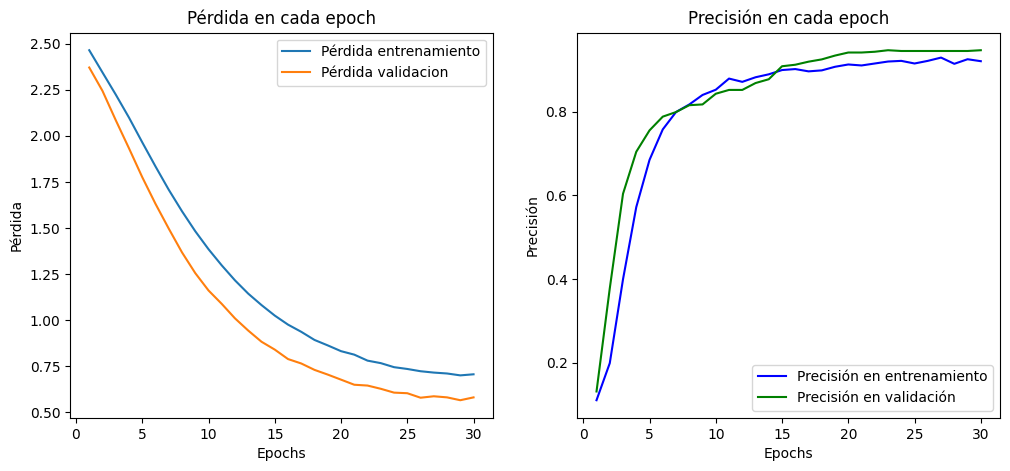

In [ ]:
# Graficar pérdida
plt.figure(figsize=(12, 5))
# Pérdida
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label="Pérdida entrenamiento")
plt.plot(range(1, epochs + 1), val_losses, label="Pérdida validacion")
plt.xlabel("Epochs")
plt.ylabel("Pérdida")
plt.title("Pérdida en cada epoch")
plt.legend()
# Precisión
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label="Precisión en entrenamiento", color="blue")
plt.plot(range(1, epochs + 1), val_accuracies, label="Precisión en validación", color="green")
plt.xlabel("Epochs")
plt.ylabel("Precisión")
plt.title("Precisión en cada epoch")
plt.legend()

plt.show()

In [ ]:
# Definir el directorio donde se guardará el modelo
output_dir = "/content/drive/MyDrive/TFM_Pruebas_Investigación/01-clasificador_pregunta_pytorch_LKLL"
# Guardar el modelo
model.save_pretrained(output_dir)
# Guardar el tokenizer
tokenizer.save_pretrained(output_dir)